In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

The autoencoder part is kind of based on [this Medium post](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1) and the PyTorch code is based on Part 1 Chapter 7 of the PyTorch book.

In [114]:
class AE_sample(nn.Module):
    '''this is copied from in the Medium post for reference
    However, this class isn't used and a format closer to the PyTorch book is used in the following code.
    https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
    '''
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=128)
        self.decoder_hidden_layer = nn.Linear(in_features=128, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])
    
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

Create autoencoder network

In [8]:
input_shape = 784
ae_model = nn.Sequential(
    ## encoder
    nn.Linear(in_features=input_shape, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
    nn.ReLU(),
    ## decoder
    nn.Linear(in_features=10, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=input_shape),
    nn.ReLU()
    )

Next, load MNIST dataset as tensors

In [9]:
from torchvision import datasets, transforms
data_path = "./data/"
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(data_path, train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(data_path, train=False, transform=transform, download=True)

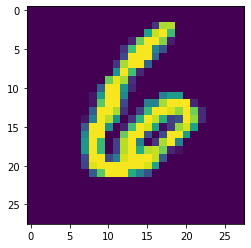

number:6	size:torch.Size([1, 28, 28])


In [10]:
img, number = mnist[13]

plt.imshow(img.permute(1,2,0))
plt.show()
print(f"number:{number}\tsize:{img.shape}")

Of course, before training, the autoencoder just emits gibberish. 

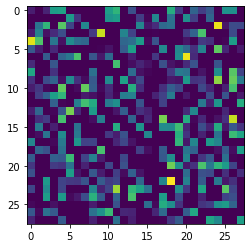

In [11]:
out = ae_model(img.view(-1).unsqueeze(0))
plt.imshow(out.view(1,28,28).permute(1,2,0).detach()) # detach disables the gradient or something
plt.show()

Finally, run the training. Hyperparameters are very arbitrarily decided by me, for now...

In [12]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)
learning_rate = 1e-3

optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

n_epochs = 10

for epoch in range(n_epochs):
    loss = 0
    for imgs, _ in train_loader:
        inputs = imgs.view(imgs.shape[0], -1)
        outputs = ae_model(inputs)
        train_loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss/len(train_loader)
    print(f"Epoch: {epoch}\tLoss: {loss}")

Epoch: 0	Loss: 0.04373204544807474
Epoch: 1	Loss: 0.02799814660102129
Epoch: 2	Loss: 0.02581868288417657
Epoch: 3	Loss: 0.024610520331189035
Epoch: 4	Loss: 0.023793357045700153
Epoch: 5	Loss: 0.02329872075157861
Epoch: 6	Loss: 0.022887218249961733
Epoch: 7	Loss: 0.022574516652772825
Epoch: 8	Loss: 0.022281958227977156
Epoch: 9	Loss: 0.022049786538506547


Show the autoencoder applied to some of the data in the verification dataset. As you can see, the autoencoder can vaguely re-create the given data!

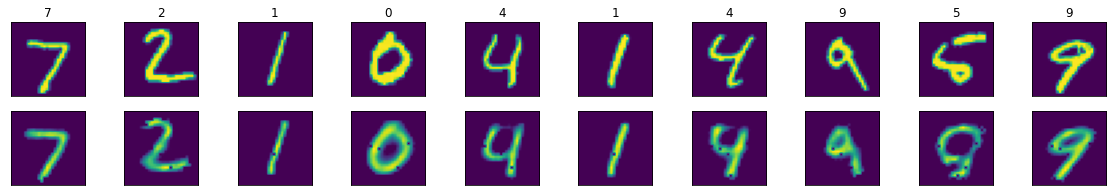

In [13]:
N = 10
fig = plt.figure(figsize=(N*2,3))
for i in range(N):
    in_t, number = mnist_val[i]
    out_t = ae_model(in_t.view(-1).unsqueeze(0))
    in_img = in_t.permute(1,2,0)
    out_img = out_t.view(1,28,28).permute(1,2,0).detach()
    ax = fig.add_subplot(2, N, 1 + i, xticks=[], yticks=[])
    ax.set_title(f"{number}")
    plt.imshow(in_img)
    ax = fig.add_subplot(2, N, 1 + N + i, xticks=[], yticks=[])
    plt.imshow(out_img)
plt.show()